In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay, precision_recall_curve, auc,
    mean_squared_error, mean_absolute_error, r2_score
)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

DATA_PATH = "telco.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())
display(df.dtypes.value_counts())


Shape: (7043, 50)


,Customer ID,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,...,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Label,Churn Score,CLTV,Churn Category,Churn Reason
0,8779-QRDMV,Male,78,No,Yes,No,No,0,United States,California,...,20,0.00,59.65,3,Churned,Yes,91,5433,Competitor,Competitor offered more data
1,7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,United States,California,...,0,390.80,1024.10,3,Churned,Yes,69,5302,Competitor,Competitor made better offer
2,1658-BYGOY,Male,71,No,Yes,No,Yes,3,United States,California,...,0,203.94,1910.88,2,Churned,Yes,81,3179,Competitor,Competitor made better offer
3,4598-XLKNJ,Female,78,No,Yes,Yes,Yes,1,United States,California,...,0,494.00,2995.07,2,Churned,Yes,88,5337,Dissatisfaction,Limited range of services
4,4846-WHAFZ,Female,80,No,Yes,Yes,Yes,1,United States,California,...,0,234.21,3102.36,2,Churned,Yes,67,2793,Price,Extra data charges


,count
object,31
int64,11
float64,8


In [6]:
df = df.copy()

if "Churn Label" not in df.columns:
    raise ValueError("Expected column 'Churn Label' not found in your CSV.")

y_class = df["Churn Label"].map({"Yes": 1, "No": 0})
if y_class.isna().any():

    print("Unexpected values in Churn Label:", df["Churn Label"].unique())
    raise ValueError("Churn Label has values beyond Yes/No. Clean mapping needed.")


if "Churn Score" not in df.columns:
    raise ValueError("Expected column 'Churn Score' not found in your CSV.")
y_reg = pd.to_numeric(df["Churn Score"], errors="coerce")


leakage_cols = [
    "Customer Status",
    "Churn Label",
    "Churn Category",
    "Churn Reason"
]


leakage_for_classification = leakage_cols + ["Churn Score"]


id_cols = ["Customer ID"]


X_class = df.drop(columns=[c for c in leakage_for_classification + id_cols if c in df.columns])
X_reg   = df.drop(columns=[c for c in leakage_cols + id_cols if c in df.columns])  # keep Churn Score out because it's target y_reg anyway


Churn rate: 0.265


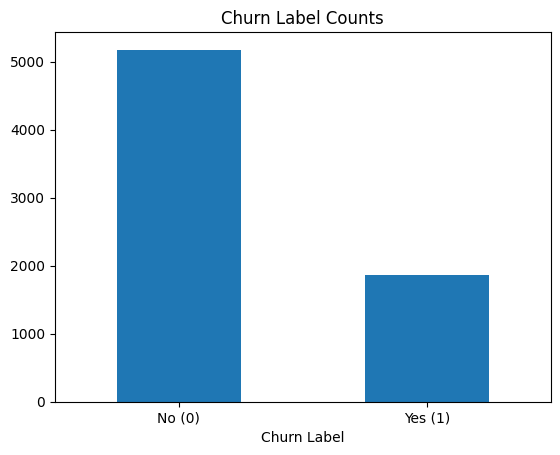

In [7]:
print("Churn rate:", y_class.mean().round(3))

ax = y_class.value_counts().sort_index().plot(kind="bar")
ax.set_xticklabels(["No (0)", "Yes (1)"], rotation=0)
ax.set_title("Churn Label Counts")
plt.show()


In [8]:
num_cols = X_class.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_class.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric features:", len(num_cols))
print("Categorical features:", len(cat_cols))
display(pd.DataFrame({"numeric": num_cols}).head(20))
display(pd.DataFrame({"categorical": cat_cols}).head(20))


Numeric features: 18
Categorical features: 26


,numeric
0,Age
1,Number of Dependents
2,Zip Code
3,Latitude
4,Longitude
5,Population
6,Number of Referrals
7,Tenure in Months
8,Avg Monthly Long Distance Charges
9,Avg Monthly GB Download


,categorical
0,Gender
1,Under 30
2,Senior Citizen
3,Married
4,Dependents
5,Country
6,State
7,City
8,Quarter
9,Referred a Friend


In [9]:
missing = X_class.isna().mean().sort_values(ascending=False)
display(missing[missing > 0].head(30))


,0
Offer,0.550476
Internet Type,0.216669


In [10]:
def churn_lift_table(data_X, y, col, top_n=15):
    tmp = pd.DataFrame({col: data_X[col], "Churn": y}).copy()
    out = (tmp.groupby(col)["Churn"]
           .agg(churn_rate="mean", n="size")
           .reset_index()
           .sort_values(["churn_rate","n"], ascending=[False, False]))
    return out.head(top_n)

for col in cat_cols[:12]:
    display(churn_lift_table(X_class, y_class, col))


,Gender,churn_rate,n
0,Female,0.269209,3488
1,Male,0.261603,3555


,Under 30,churn_rate,n
0,No,0.277384,5642
1,Yes,0.216988,1401


,Senior Citizen,churn_rate,n
1,Yes,0.416813,1142
0,No,0.236062,5901


,Married,churn_rate,n
0,No,0.329580,3641
1,Yes,0.196649,3402


,Dependents,churn_rate,n
0,No,0.325517,5416
1,Yes,0.065151,1627


,Country,churn_rate,n
0,United States,0.26537,7043


,State,churn_rate,n
0,California,0.26537,7043


,City,churn_rate,n
104,Boulder Creek,1.000,4
827,Riverbank,1.000,4
927,Smith River,1.000,4
1017,Twain,1.000,4
1096,Wrightwood,1.000,4
295,Eldridge,1.000,2
460,Johannesburg,1.000,2
943,South Lake Tahoe,1.000,2
855,San Dimas,0.875,8
0,Acampo,0.750,4


,Quarter,churn_rate,n
0,Q3,0.26537,7043


,Referred a Friend,churn_rate,n
0,No,0.325831,3821
1,Yes,0.193669,3222


,Offer,churn_rate,n
4,Offer E,0.529193,805
3,Offer D,0.267442,602
2,Offer C,0.228916,415
1,Offer B,0.122573,824
0,Offer A,0.067308,520


,Phone Service,churn_rate,n
1,Yes,0.267096,6361
0,No,0.249267,682


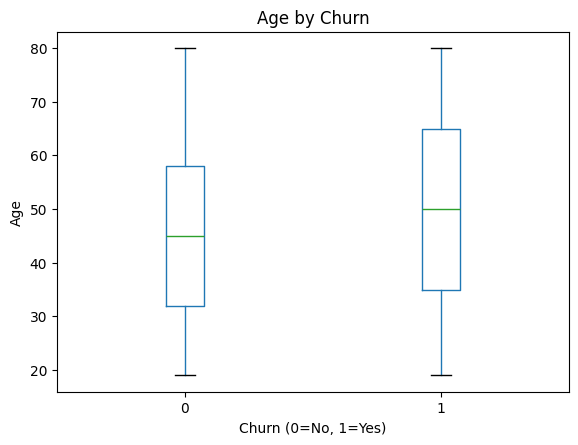

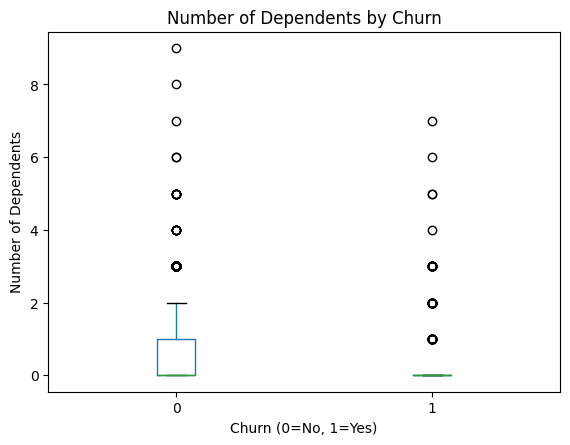

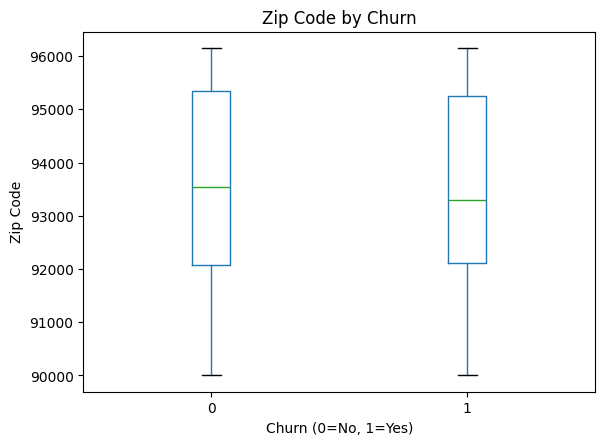

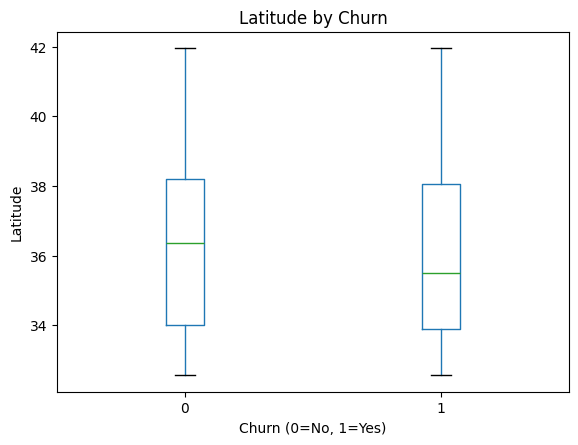

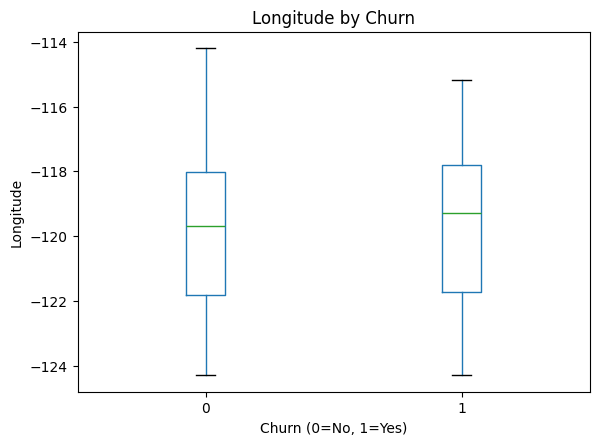

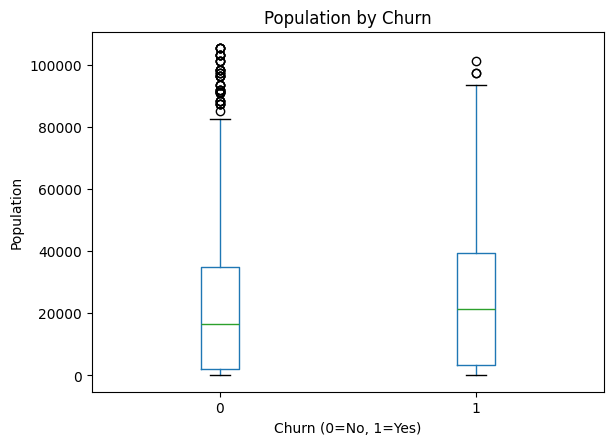

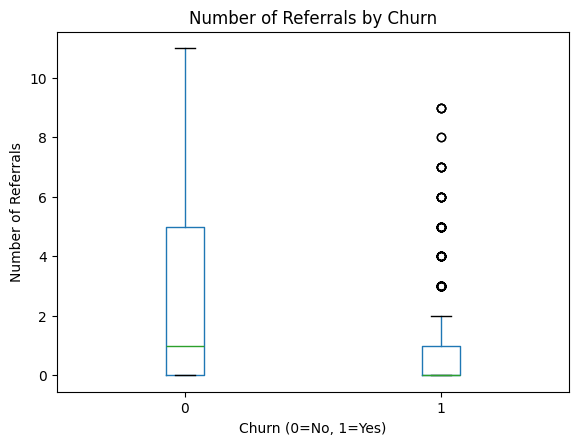

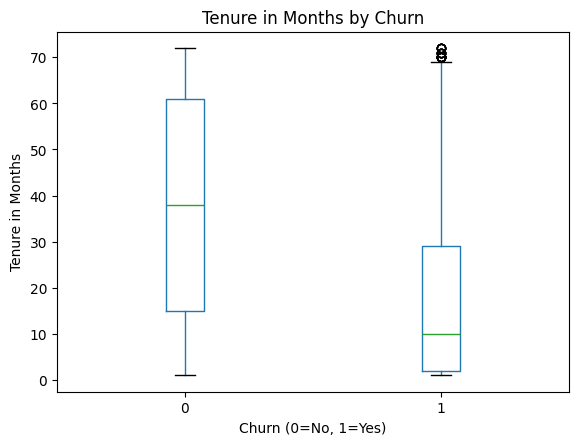

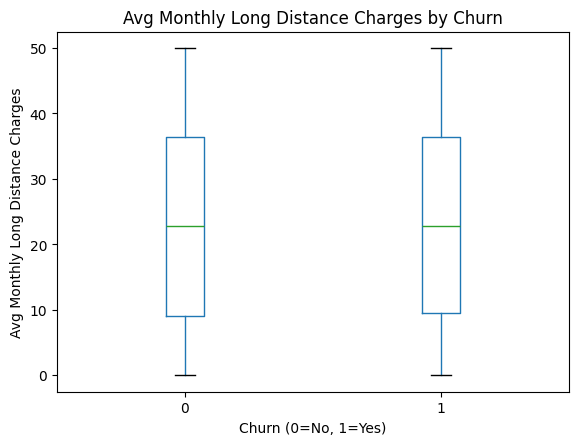

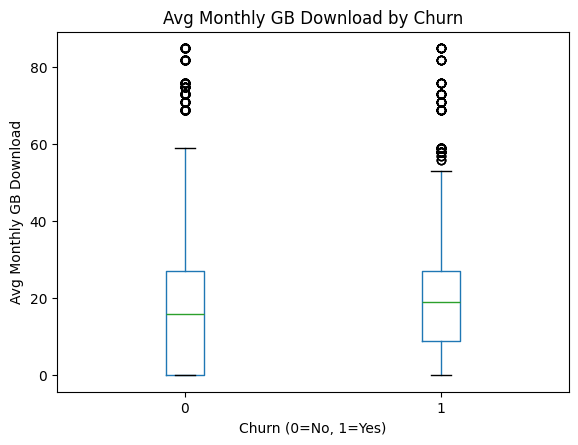

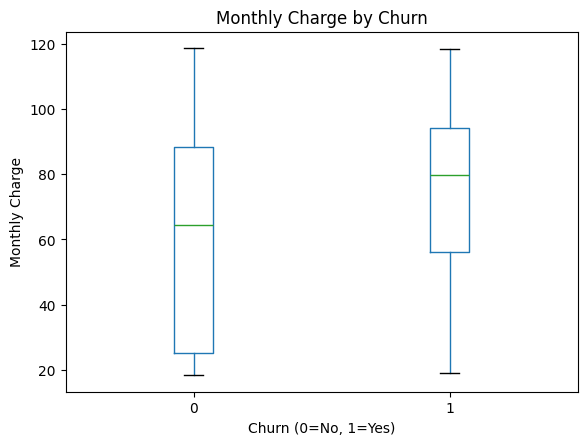

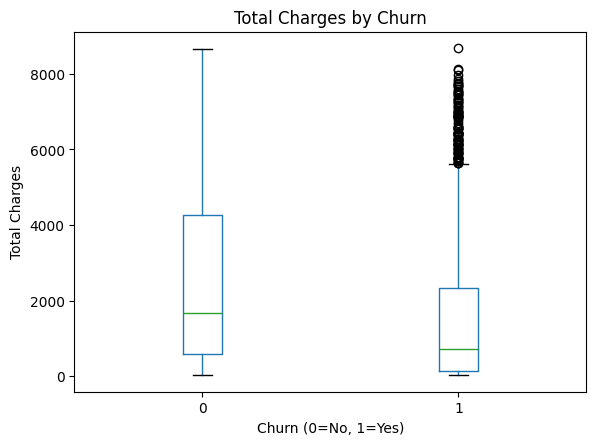

In [11]:
for col in num_cols[:12]:
    tmp = pd.DataFrame({col: X_class[col], "Churn": y_class})
    tmp.boxplot(column=col, by="Churn", grid=False)
    plt.title(f"{col} by Churn")
    plt.suptitle("")
    plt.xlabel("Churn (0=No, 1=Yes)")
    plt.ylabel(col)
    plt.show()


In [12]:
numeric_features = X_class.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_class.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)


              precision    recall  f1-score   support

           0      0.974     0.959     0.966      1035
           1      0.892     0.928     0.910       374

    accuracy                          0.951      1409
   macro avg      0.933     0.944     0.938      1409
weighted avg      0.952     0.951     0.951      1409

ROC-AUC: 0.9918


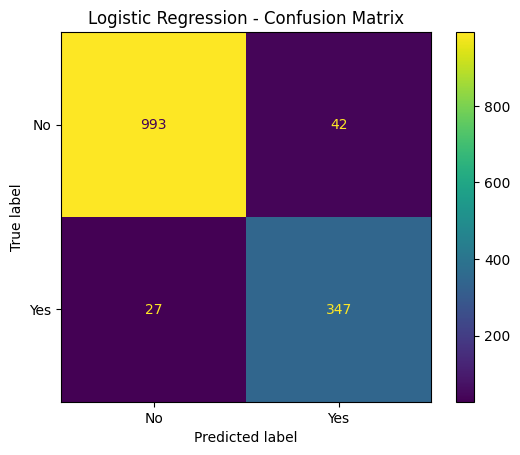

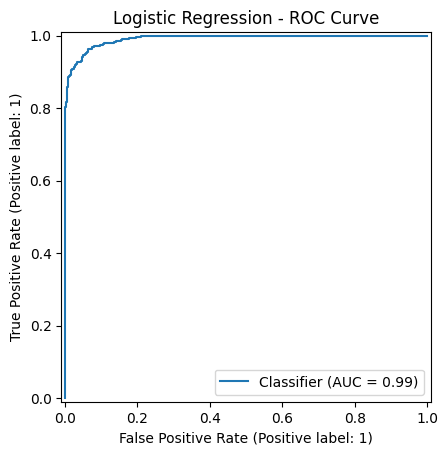

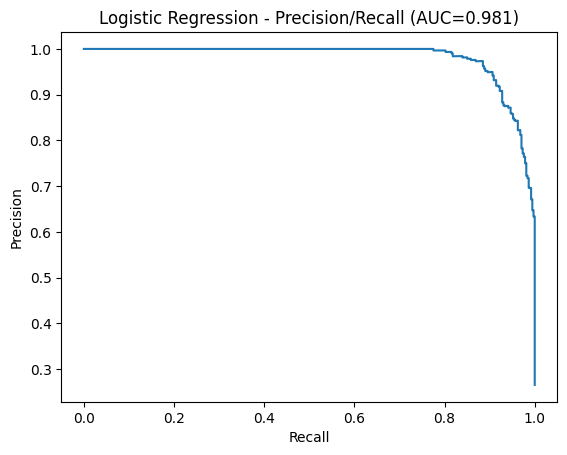

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

log_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

log_clf.fit(X_train, y_train)

y_pred = log_clf.predict(X_test)
y_proba = log_clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba).round(4))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["No","Yes"]).plot()
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Logistic Regression - ROC Curve")
plt.show()

prec, rec, thr = precision_recall_curve(y_test, y_proba)
pr_auc = auc(rec, prec)
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Logistic Regression - Precision/Recall (AUC={pr_auc:.3f})")
plt.show()


In [14]:
# Get final feature names after one-hot encoding
ohe = log_clf.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = np.r_[numeric_features, cat_names]

coefs = log_clf.named_steps["model"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df["odds_ratio"] = np.exp(coef_df["coef"])

display(coef_df.sort_values("abs_coef", ascending=False).head(25))


,feature,coef,abs_coef,odds_ratio
16,Satisfaction Score,-6.932021,6.932021,0.000976
6,Number of Referrals,-1.851888,1.851888,0.156941
609,City_March Air Reserve Base,1.695227,1.695227,5.447881
882,City_San Diego,1.578481,1.578481,4.847588
1152,Online Security_Yes,-1.546992,1.546992,0.212887
921,City_Santa Rosa,1.523907,1.523907,4.590123
728,City_Olivehurst,1.490008,1.490008,4.437130
345,City_Fallbrook,1.467427,1.467427,4.338060
730,City_Ontario,1.457228,1.457228,4.294042
138,City_Brea,1.394971,1.394971,4.034856


Regression target: Churn Score
RMSE: 0.015
MAE : 0.011
R^2 : 1.0


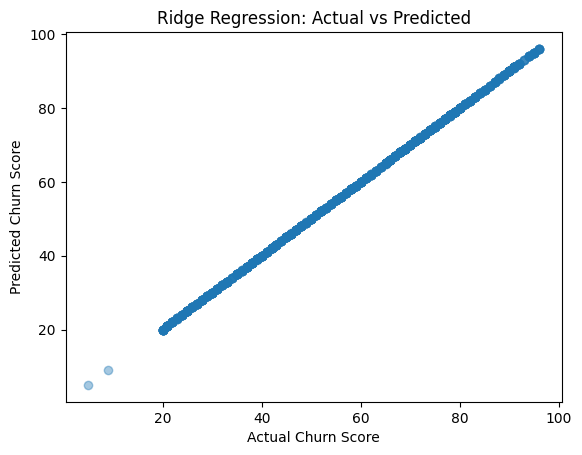

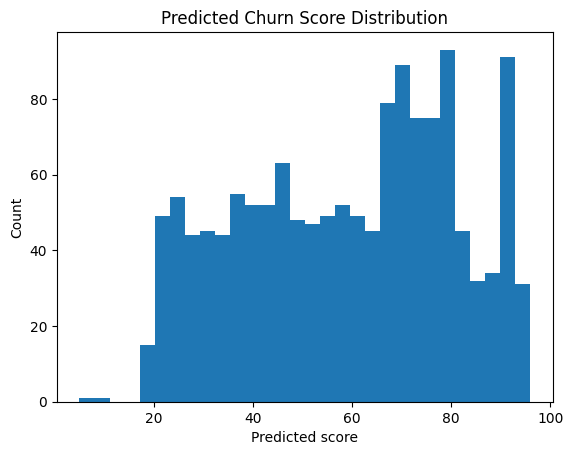

In [18]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

num_cols_reg = X_reg.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_reg = X_reg.select_dtypes(exclude=[np.number]).columns.tolist()

preprocess_reg = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols_reg),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols_reg)
    ],
    remainder="drop"
)

ridge = Pipeline(steps=[
    ("preprocess", preprocess_reg),
    ("model", Ridge(alpha=1.0, random_state=42))
])

ridge.fit(Xr_train, yr_train)
yr_pred = ridge.predict(Xr_test)

rmse = np.sqrt(mean_squared_error(yr_test, yr_pred))
mae  = mean_absolute_error(yr_test, yr_pred)
r2   = r2_score(yr_test, yr_pred)

print("Regression target: Churn Score")
print("RMSE:", np.round(rmse, 3))
print("MAE :", np.round(mae, 3))
print("R^2 :", np.round(r2, 3))

plt.scatter(yr_test, yr_pred, alpha=0.4)
plt.xlabel("Actual Churn Score")
plt.ylabel("Predicted Churn Score")
plt.title("Ridge Regression: Actual vs Predicted")
plt.show()

plt.hist(yr_pred, bins=30)
plt.title("Predicted Churn Score Distribution")
plt.xlabel("Predicted score")
plt.ylabel("Count")
plt.show()


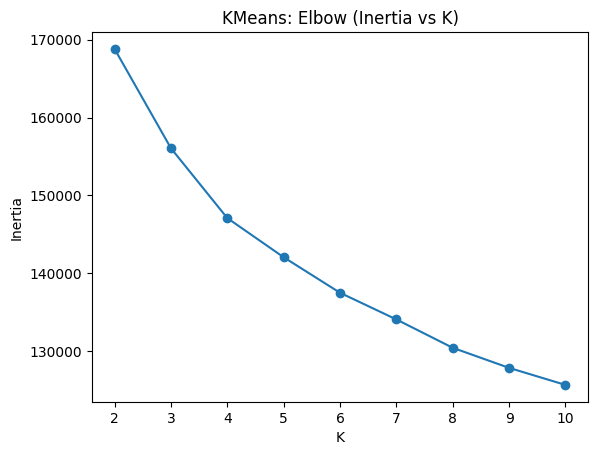

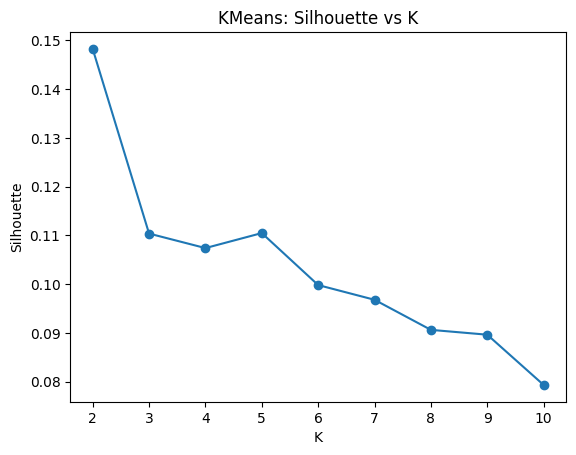

Selected K (max silhouette): 2


,Cluster,n,churn_rate
0,0,4629,0.323180
1,1,2414,0.154515


,Tenure in Months,Monthly Charge,Total Revenue,CLTV,Age
Cluster,,,,,
0,20.142147,52.118341,1290.007075,4137.010153,46.019875
1,55.866611,89.006131,6379.324333,4905.162800,47.449047



=== Contract ===


,Cluster,Contract,count
0,0,Month-to-Month,3032
2,0,Two Year,841
1,0,One Year,756
5,1,Two Year,1042
4,1,One Year,794
3,1,Month-to-Month,578



=== Offer ===


,Cluster,Offer,count
4,0,Offer E,804
3,0,Offer D,589
2,0,Offer C,280
1,0,Offer B,261
0,0,Offer A,90
6,1,Offer B,563
5,1,Offer A,430
7,1,Offer C,135
8,1,Offer D,13
9,1,Offer E,1



=== Internet Type ===


,Cluster,Internet Type,count
2,0,Fiber Optic,1539
1,0,DSL,1055
0,0,Cable,535
5,1,Fiber Optic,1496
4,1,DSL,597
3,1,Cable,295



=== Payment Method ===


,Cluster,Payment Method,count
0,0,Bank Withdrawal,2423
1,0,Credit Card,1864
2,0,Mailed Check,342
3,1,Bank Withdrawal,1486
4,1,Credit Card,885
5,1,Mailed Check,43


In [26]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


if "df" not in globals():
    raise NameError("df is not defined. Load your data first (df = pd.read_csv(...)).")

drop_cols = [c for c in ["Customer Status", "Churn Label", "Churn Category", "Churn Reason", "Churn Score", "Customer ID"]
             if c in df.columns]
X = df.drop(columns=drop_cols, errors="ignore")


num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop"
)


svd_components = 50

cluster_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("svd", TruncatedSVD(n_components=svd_components, random_state=42))
])

X_all_cluster = cluster_pipe.fit_transform(X)


Ks = range(2, 11)
sils, inertias = [], []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_all_cluster)
    sils.append(silhouette_score(X_all_cluster, labels))
    inertias.append(km.inertia_)

plt.plot(list(Ks), inertias, marker="o")
plt.title("KMeans: Elbow (Inertia vs K)")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.show()

plt.plot(list(Ks), sils, marker="o")
plt.title("KMeans: Silhouette vs K")
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.show()

k = int(Ks[np.argmax(sils)])
print("Selected K (max silhouette):", k)


kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_all_cluster)

df_seg = df.copy()
df_seg["Cluster"] = clusters


if "Churn Label" in df_seg.columns:
    summary = (
        df_seg.groupby("Cluster")
        .agg(
            n=("Cluster", "size"),
            churn_rate=("Churn Label", lambda s: (s == "Yes").mean())
        )
        .reset_index()
        .sort_values("churn_rate", ascending=False)
    )
else:
    summary = df_seg["Cluster"].value_counts().sort_index().reset_index()
    summary.columns = ["Cluster", "n"]

display(summary)

optional_nums = [c for c in ["Tenure in Months", "Monthly Charge", "Total Revenue", "CLTV", "Age"] if c in df_seg.columns]
if optional_nums:
    display(df_seg.groupby("Cluster")[optional_nums].mean(numeric_only=True))

key_cats = [c for c in ["Contract", "Offer", "Internet Type", "Payment Method"] if c in df_seg.columns]
for c in key_cats:
    print(f"\n=== {c} ===")
    display(
        df_seg.groupby(["Cluster", c]).size()
        .reset_index(name="count")
        .sort_values(["Cluster", "count"], ascending=[True, False])
        .groupby("Cluster")
        .head(5)
    )
